## Empirical Assessment of Technical Analysis: High-frequency Data

In [3]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\tamo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install mplfinance


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\tamo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\tamo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### 1. Introduction, Data Availability:

Intraday 1-minute data for the major stocks can be obtained for free in .csv format here: https://firstratedata.com/free-intraday-data. These will probably serve as our initial source. Using data for AAPL we will try to sketch our first technical analysis algorithm.

In [4]:
import pandas as pd
import mplfinance as fplt
import plotly.graph_objects as go
from ta.utils import dropna
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt
import math
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [5]:
df = pd.read_csv("AAPL_1min_firstratedata.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

#selecting a random day
day_df_1 = df[df['Date'].dt.date == pd.to_datetime("2022-10-19").date()].set_index("Date")
day_df_1

,Open,High,Low,Close,Volume
Date,,,,,
2022-10-19 04:00:00,144.06,144.15,143.40,143.47,5842
2022-10-19 04:01:00,143.41,143.41,143.22,143.27,2488
2022-10-19 04:02:00,143.42,143.50,143.26,143.28,2645
2022-10-19 04:04:00,143.35,143.36,143.31,143.35,1191
2022-10-19 04:05:00,143.29,143.30,143.26,143.30,655
...,...,...,...,...,...
2022-10-19 19:55:00,143.00,143.00,143.00,143.00,450
2022-10-19 19:56:00,143.00,143.00,143.00,143.00,1055
2022-10-19 19:57:00,143.00,143.00,142.95,142.96,2540


In [10]:
candlestick = go.Candlestick(x=day_df_1.index, open=day_df_1['Open'], high=day_df_1['High'], low=day_df_1['Low'], close=day_df_1['Close'])
fig = go.Figure(data=[candlestick])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


### 2. Patterns & Indicators

#### Bollinger Bands

The Bollinger Bands are used to analyze the volatility of the price for an asset in a specific period of time. There are 3 bands, the Middle Band (MB) is the average of the price in the last n periods, the Upper (UB) and Lower Bands (LB) are equal to the middle band, but adding and subtracting x times the standard deviation. The normal parameters that are being used are n = 20 periods and x = 2.5.

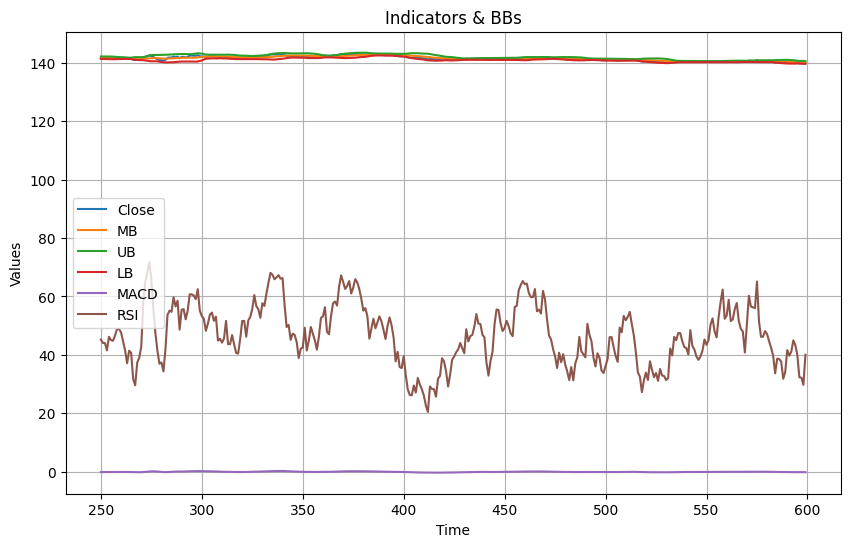

In [8]:
indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2.5)

df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbu'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

df['MACD'] = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9).macd()
df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()


# Plotting
plot_df = df.iloc[250:600]

plt.figure(figsize=(10, 6))
plt.plot(plot_df['Close'], label='Close')
plt.plot(plot_df['bb_bbm'], label='MB')
plt.plot(plot_df['bb_bbu'], label='UB')
plt.plot(plot_df['bb_bbl'], label='LB')
plt.plot(plot_df['MACD'], label='MACD')  # Added MACD
plt.plot(plot_df['RSI'], label='RSI')  # Added RSI
plt.title('Indicators & BBs')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


### 3. Backtesting

In [ ]:
def backtest(df, investment, method):
    in_position = False
    equity = investment

    for i in range(30, len(df)):
        # Check if any indicator has NaN value, skip iteration if true
        if not all(pd.notna(df.loc[i, ['bb_bbm', 'bb_bbu', 'bb_bbl', 'MACD', 'RSI']])):
            continue

        # Print debug information
        print(f"Index: {i}, RSI: {df['RSI'][i]}, MACD: {df['MACD'][i]}")

        # Existing code for buy and sell conditions
        if df['bb_bbl'][i] > df['Close'][i] and not in_position:
            no_of_shares = math.floor(equity / df.Close[i])
            equity -= (no_of_shares * df.Close[i])
            in_position = True
            print(f'BUY: {no_of_shares} Shares are bought at ${df.Close[i]} on {str(df.Date[i])}')

        elif df['bb_bbu'][i] < df['Close'][i] and in_position:
            equity += (no_of_shares * df.Close[i])
            in_position = False
            print(f'SELL: {no_of_shares} Shares are sold at ${df.Close[i]} on {str(df.Date[i])}')

        # Add additional conditions for selling
        elif df['RSI'][i] > 70 and df['MACD'][i] < 0 and in_position:
            equity += (no_of_shares * df.Close[i])
            in_position = False
            print(f'SELL: {no_of_shares} Shares are sold at ${df.Close[i]} on {str(df.Date[i])}')

    if in_position:
        # Close position at the end of the loop
        equity += (no_of_shares * df.Close[i])
        print(f'Closing position at {df.Close[i]} on {str(df.Date[i])}')
        in_position = False

    earning = round(equity - investment, 2)
    print(f'EARNING: {earning}')

# Assuming your DataFrame is named 'df'
backtest(df, 10000, "BB")

Index: 30, RSI: 51.970072454857686, MACD: -0.028371961043319516
Index: 31, RSI: 53.24986990388774, MACD: -0.019923717441400868
Index: 32, RSI: 54.55396712756055, MACD: -0.011482230659908055
Index: 33, RSI: 54.55396712756055, MACD: -0.004737678558655034
Index: 34, RSI: 51.23865637813615, MACD: -0.002590377868983751
Index: 35, RSI: 58.09494391202339, MACD: 0.007098708174140711
Index: 36, RSI: 63.605922870077585, MACD: 0.022586183470934884
Index: 37, RSI: 59.399618728811255, MACD: 0.030474248920313585
Index: 38, RSI: 62.09885050835598, MACD: 0.040295676278987
Index: 39, RSI: 65.55179345105817, MACD: 0.05311536237167047
Index: 40, RSI: 62.906695316076025, MACD: 0.06016081030895748
Index: 41, RSI: 52.93813136402403, MACD: 0.05462478450132835
Index: 42, RSI: 49.67746410933911, MACD: 0.04567633368907309
Index: 43, RSI: 50.97814946616522, MACD: 0.039740352754222386
Index: 44, RSI: 52.305729245257226, MACD: 0.036232215523142486
Index: 45, RSI: 52.305729245257226, MACD: 0.03307077221649024
Index

In [17]:
df

,Date,Open,High,Low,Close,Volume,bb_bbm,bb_bbu,bb_bbl,MACD,RSI
0,2022-09-30 04:00:00,143.59,143.59,143.10,143.49,4060,NaN,NaN,NaN,NaN,NaN
1,2022-09-30 04:01:00,143.49,143.49,143.38,143.38,481,NaN,NaN,NaN,NaN,NaN
2,2022-09-30 04:02:00,143.22,143.22,143.22,143.22,107,NaN,NaN,NaN,NaN,NaN
3,2022-09-30 04:03:00,143.39,143.39,143.21,143.23,2811,NaN,NaN,NaN,NaN,NaN
4,2022-09-30 04:04:00,143.30,143.32,143.30,143.32,309,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
193824,2023-09-29 19:45:00,171.20,171.20,171.20,171.20,800,171.251505,171.371211,171.131799,-0.055356,38.005501
193825,2023-09-29 19:46:00,171.20,171.20,171.20,171.20,1917,171.247505,171.369180,171.125830,-0.053777,38.005501
193826,2023-09-29 19:47:00,171.20,171.21,171.20,171.21,594,171.246505,171.369560,171.123450,-0.051129,39.725063
193827,2023-09-29 19:48:00,171.21,171.21,171.21,171.21,768,171.245005,171.369631,171.120379,-0.048472,39.725063


###  Coming soon: Short positions, more patterns & indicators, ...